In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import sqlite3 as sqlite
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, IsolationForest
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import joblib

In [2]:
os.listdir()

['.ipynb_checkpoints',
 'Aprekini.csv',
 'Backup Julyter',
 'creditscore_ml_predict_GBR.joblib',
 'Final.xlsx',
 'iztirits.csv',
 'iztiritsBACKUP.csv',
 'NoslegumaDarbs_Alksnitis BACKUP 5 2.12.2025.ipynb',
 'NoslegumaDarbs_Alksnitis BACKUP 9 10.12.2025.ipynb',
 'NoslegumaDarbs_Alksnitis.ipynb',
 'PBI',
 'score-graphic.png',
 'SQLite',
 'test.csv']

### Datu tīrīšana

In [3]:
df = pd.read_csv("test.csv")

In [4]:
def datu_tirisana(df):
#     - Noņemt no kolonnam liekās atstarpes
    df.columns = df.columns.str.strip()
    
# 	- Noņemt visur "_" izņemot "Payment_Behaviour" kolonnai
    cols_to_clean = [col for col in df.columns if col not in ["Payment_Behaviour","Customer_ID"]]
    df[cols_to_clean] = df[cols_to_clean].replace("_", "", regex = True)
    
# 	- Noņemt " '` " kolonnām
    df[cols_to_clean] = df[cols_to_clean].replace("`","", regex = True)
    df[cols_to_clean] = df[cols_to_clean].replace("'","", regex = True)
    
# 	- Aizvietot visas tukšās, kā arī "NA" vērtības ar np.nan
    df = df.replace(r'^\s*$', np.nan, regex=True)
    df = df.replace(["NA", "na", "N/A", "n/a"], np.nan, regex=True)
    
    # - Aizvietot tukšos Type_of_Loan ar "Not Specified"
    df["Type_of_Loan"] = df["Type_of_Loan"].fillna("Not Specified")

# 	- Salabot nekorektos vai trūkstošos datus kolonnās balstoties uz Customer_ID kolonnu
# 		○ Name, SSN, Age, Occupation, Monthly_Inhand_Salary, Credit_Mix, Payment_Behavior, Num_of_Loan, 
    # Interest_Rate, Num_Credit_Card, Num_Bank_Account, Annual_Income, Type_of_Loan, Payment_of_Min_Amount, 
    # Changed_Credit_Limit, Outstanding_Debt, Total_EMI_per_month
    Correction_cols = ["Name", "SSN", "Age", "Occupation", "Monthly_Inhand_Salary", "Credit_Mix", "Payment_Behaviour",
                       "Num_of_Loan", "Interest_Rate", "Num_Credit_Card", "Num_Bank_Accounts", "Annual_Income",
                       "Type_of_Loan", "Payment_of_Min_Amount", "Changed_Credit_Limit", "Outstanding_Debt", "Total_EMI_per_month"]

    for col in Correction_cols:
        grouped = df.groupby("Customer_ID")[col]
        value_by_id = grouped.apply(lambda x: x.value_counts().idxmax() if x.dropna().size > 0 else np.nan)
        df[col] = df["Customer_ID"].map(value_by_id)

    df["Amount_invested_monthly"] = pd.to_numeric(df["Amount_invested_monthly"], errors="coerce")
    
# 	- Kolonnā Num_of_Delayed_Payment tukšajās vietās ielikt konkrētā Customer_ID Num_of_Delayed_Payment mediānu
    df["Num_of_Delayed_Payment"] = pd.to_numeric(df["Num_of_Delayed_Payment"], errors="coerce")
    grouped_delay_payment = df.groupby("Customer_ID")["Num_of_Delayed_Payment"]
    delay_median = grouped_delay_payment.apply(lambda x: x.median() if x.dropna().size > 0 else np.nan)
    df["Num_of_Delayed_Payment"] = df["Customer_ID"].map(delay_median)
    
# 	- Komentārs Parcik nevar aprēķināt EMI, jo trūkt info kā kopējā aizdevuma summa, un termiņš, drop Total_EMI_per_month rindas, kurās ir 0
    df["Total_EMI_per_month"] = df["Total_EMI_per_month"].replace(0,np.nan)
    df = df.dropna(subset=["Total_EMI_per_month"])
    
# 	- Kolonnā Amount_invested_monthly katram Customer_ID, tukšajā vietā ievietot viņa veikto ieguldījumu Mediānu
    df["Amount_invested_monthly"] = pd.to_numeric(df["Amount_invested_monthly"], errors="coerce")
    grouped_invested_monthly = df.groupby("Customer_ID")["Amount_invested_monthly"]
    investment_median = grouped_invested_monthly.apply(lambda x: x.median() if x.dropna().size > 0 else np.nan)
    df["Amount_invested_monthly"] = df["Customer_ID"].map(investment_median)
    
# - Kolonna Num_Credit_Inquiries visu, kas ir virs 10 aizstāt ar konkrētā klienta mediānu.
    grouped_credit_inquiries = df.groupby("Customer_ID")["Num_Credit_Inquiries"]
    inquirie_median = grouped_credit_inquiries.apply(lambda x: x.median() if x.dropna().size > 0 else np.nan)
    df.loc[df["Num_Credit_Inquiries"] > 10, "Num_Credit_Inquiries"] = df.loc[df["Num_Credit_Inquiries"] > 10,"Customer_ID"].map(inquirie_median)


# 	- Credit_History_Age kolonnu no teksta izvilkt pirmo skaitli, un pārvērst par float. Tad aizpildīt df grupējot pēc Customer_ID 
    df["Credit_History_Age"] = df["Credit_History_Age"].str.extract(r'(\d+)')[0].astype(float)
    df["Credit_History_Age"] = df.groupby("Customer_ID")["Credit_History_Age"].transform(lambda s: s.fillna(s.median()))
    df["Credit_History_Age"] = df["Credit_History_Age"].round().astype("Int64")
#   - Noņemt klientus, kam kāda vērtība trūkst
    bad_customers = []

    for customer_id, group in df.groupby("Customer_ID"):
        if group.isna().any().any():
            bad_customers.append(customer_id)

    df = df[~df["Customer_ID"].isin(bad_customers)]

    df = df.astype({"Annual_Income": float,"Num_of_Loan": "Int64", "Outstanding_Debt": float, "Monthly_Balance": float, "Changed_Credit_Limit": float})

# Kolonna monthly balance visu, kas ir zem 0 aizstat ar ta klienta medianu
    grouped_monthly_balance = df.groupby("Customer_ID")["Monthly_Balance"]
    monbalance_mean = grouped_monthly_balance.apply(lambda x: x.median() if x.dropna().size > 0 else np.nan)
    df.loc[df["Monthly_Balance"] < 0, "Monthly_Balance"] = df.loc[df["Monthly_Balance"] < 0, "Customer_ID"].map(monbalance_mean)
    df["Monthly_Balance"] = df["Monthly_Balance"].round(2)
    
    df.loc[df["Num_of_Loan"] == -100, "Num_of_Loan"] = df.loc[df["Num_of_Loan"] == -100, "Type_of_Loan"].fillna("").apply(lambda x: len(x.split(",")) if x != "" else 1)
    
    df = df[df["Changed_Credit_Limit"] >= 0]

    df["Payment_Behaviour"] = df["Payment_Behaviour"].replace("!@9#%8","Low_spent_Small_value_payments", regex = True)

    df["Payment_Behaviour"] = df["Payment_Behaviour"].astype("string")
    df["Spending"] = df["Payment_Behaviour"].str.split("_").str[0]
    df["Payment_Value"] = df["Payment_Behaviour"].str.split("_").str[2]
    df["Spending"] = df["Spending"].replace("High",2)
    df["Spending"] = df["Spending"].replace("Low",1)
    df["Payment_Value"] = df["Payment_Value"].replace("Small", 1)
    df["Payment_Value"] = df["Payment_Value"].replace("Medium", 2)
    df["Payment_Value"] = df["Payment_Value"].replace("Large", 3)

    df["Num_Bank_Accounts"] = df["Num_Bank_Accounts"].replace(-1, 1)
    
    df = df.astype({"Payment_Value": "Int64", "Spending": "Int64", "Age": "Int64"})
    
    df["Credit_amount"] = df["Annual_Income"] * df["Changed_Credit_Limit"] / 100

    df = df[df["SSN"] != "#F%$D@*&8"]
    
    return df

In [5]:
df = datu_tirisana(df)

C:\Users\dinar\AppData\Local\Temp\ipykernel_7364\3727499589.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Amount_invested_monthly"] = pd.to_numeric(df["Amount_invested_monthly"], errors="coerce")
C:\Users\dinar\AppData\Local\Temp\ipykernel_7364\3727499589.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Amount_invested_monthly"] = df["Customer_ID"].map(investment_median)
C:\Users\dinar\AppData\Local\Temp\ipykernel_7364\3727499589.py:58: SettingWithCopyWarning: 
A value is trying to be set

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29344 entries, 0 to 49999
Data columns (total 30 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        29344 non-null  object 
 1   Customer_ID               29344 non-null  object 
 2   Month                     29344 non-null  object 
 3   Name                      29344 non-null  object 
 4   Age                       29344 non-null  Int64  
 5   SSN                       29344 non-null  object 
 6   Occupation                29344 non-null  object 
 7   Annual_Income             29344 non-null  float64
 8   Monthly_Inhand_Salary     29344 non-null  float64
 9   Num_Bank_Accounts         29344 non-null  int64  
 10  Num_Credit_Card           29344 non-null  int64  
 11  Interest_Rate             29344 non-null  int64  
 12  Num_of_Loan               29344 non-null  Int64  
 13  Type_of_Loan              29344 non-null  object 
 14  Delay_from_

In [7]:
# df.to_csv("iztirits.csv")

In [8]:
df.describe(include = "all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
ID,29344,29344,0x160a,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Customer_ID,29344,7336,CUS_0xd40,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Month,29344,4,September,7336,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Name,29344,6420,Stevex,24,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Age,29344.0,<NA>,<NA>,<NA>,33.527672,10.727371,14.0,25.0,33.0,42.0,56.0
SSN,29344,7336,821-00-0265,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Occupation,29344,12,Lawyer,2644,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Annual_Income,29344.0,NaN,NaN,NaN,47289.701259,36850.918211,7005.93,18465.2875,34975.015,66482.74,179987.28
Monthly_Inhand_Salary,29344.0,NaN,NaN,NaN,3911.94558,3047.61589,303.645417,1546.693542,2905.14,5482.111066,15204.63333
Num_Bank_Accounts,29344.0,NaN,NaN,NaN,5.510087,2.583368,0.0,4.0,6.0,8.0,11.0


### Credit score veidošana

In [9]:
df.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Spending', 'Payment_Value', 'Credit_amount'],
      dtype='object')

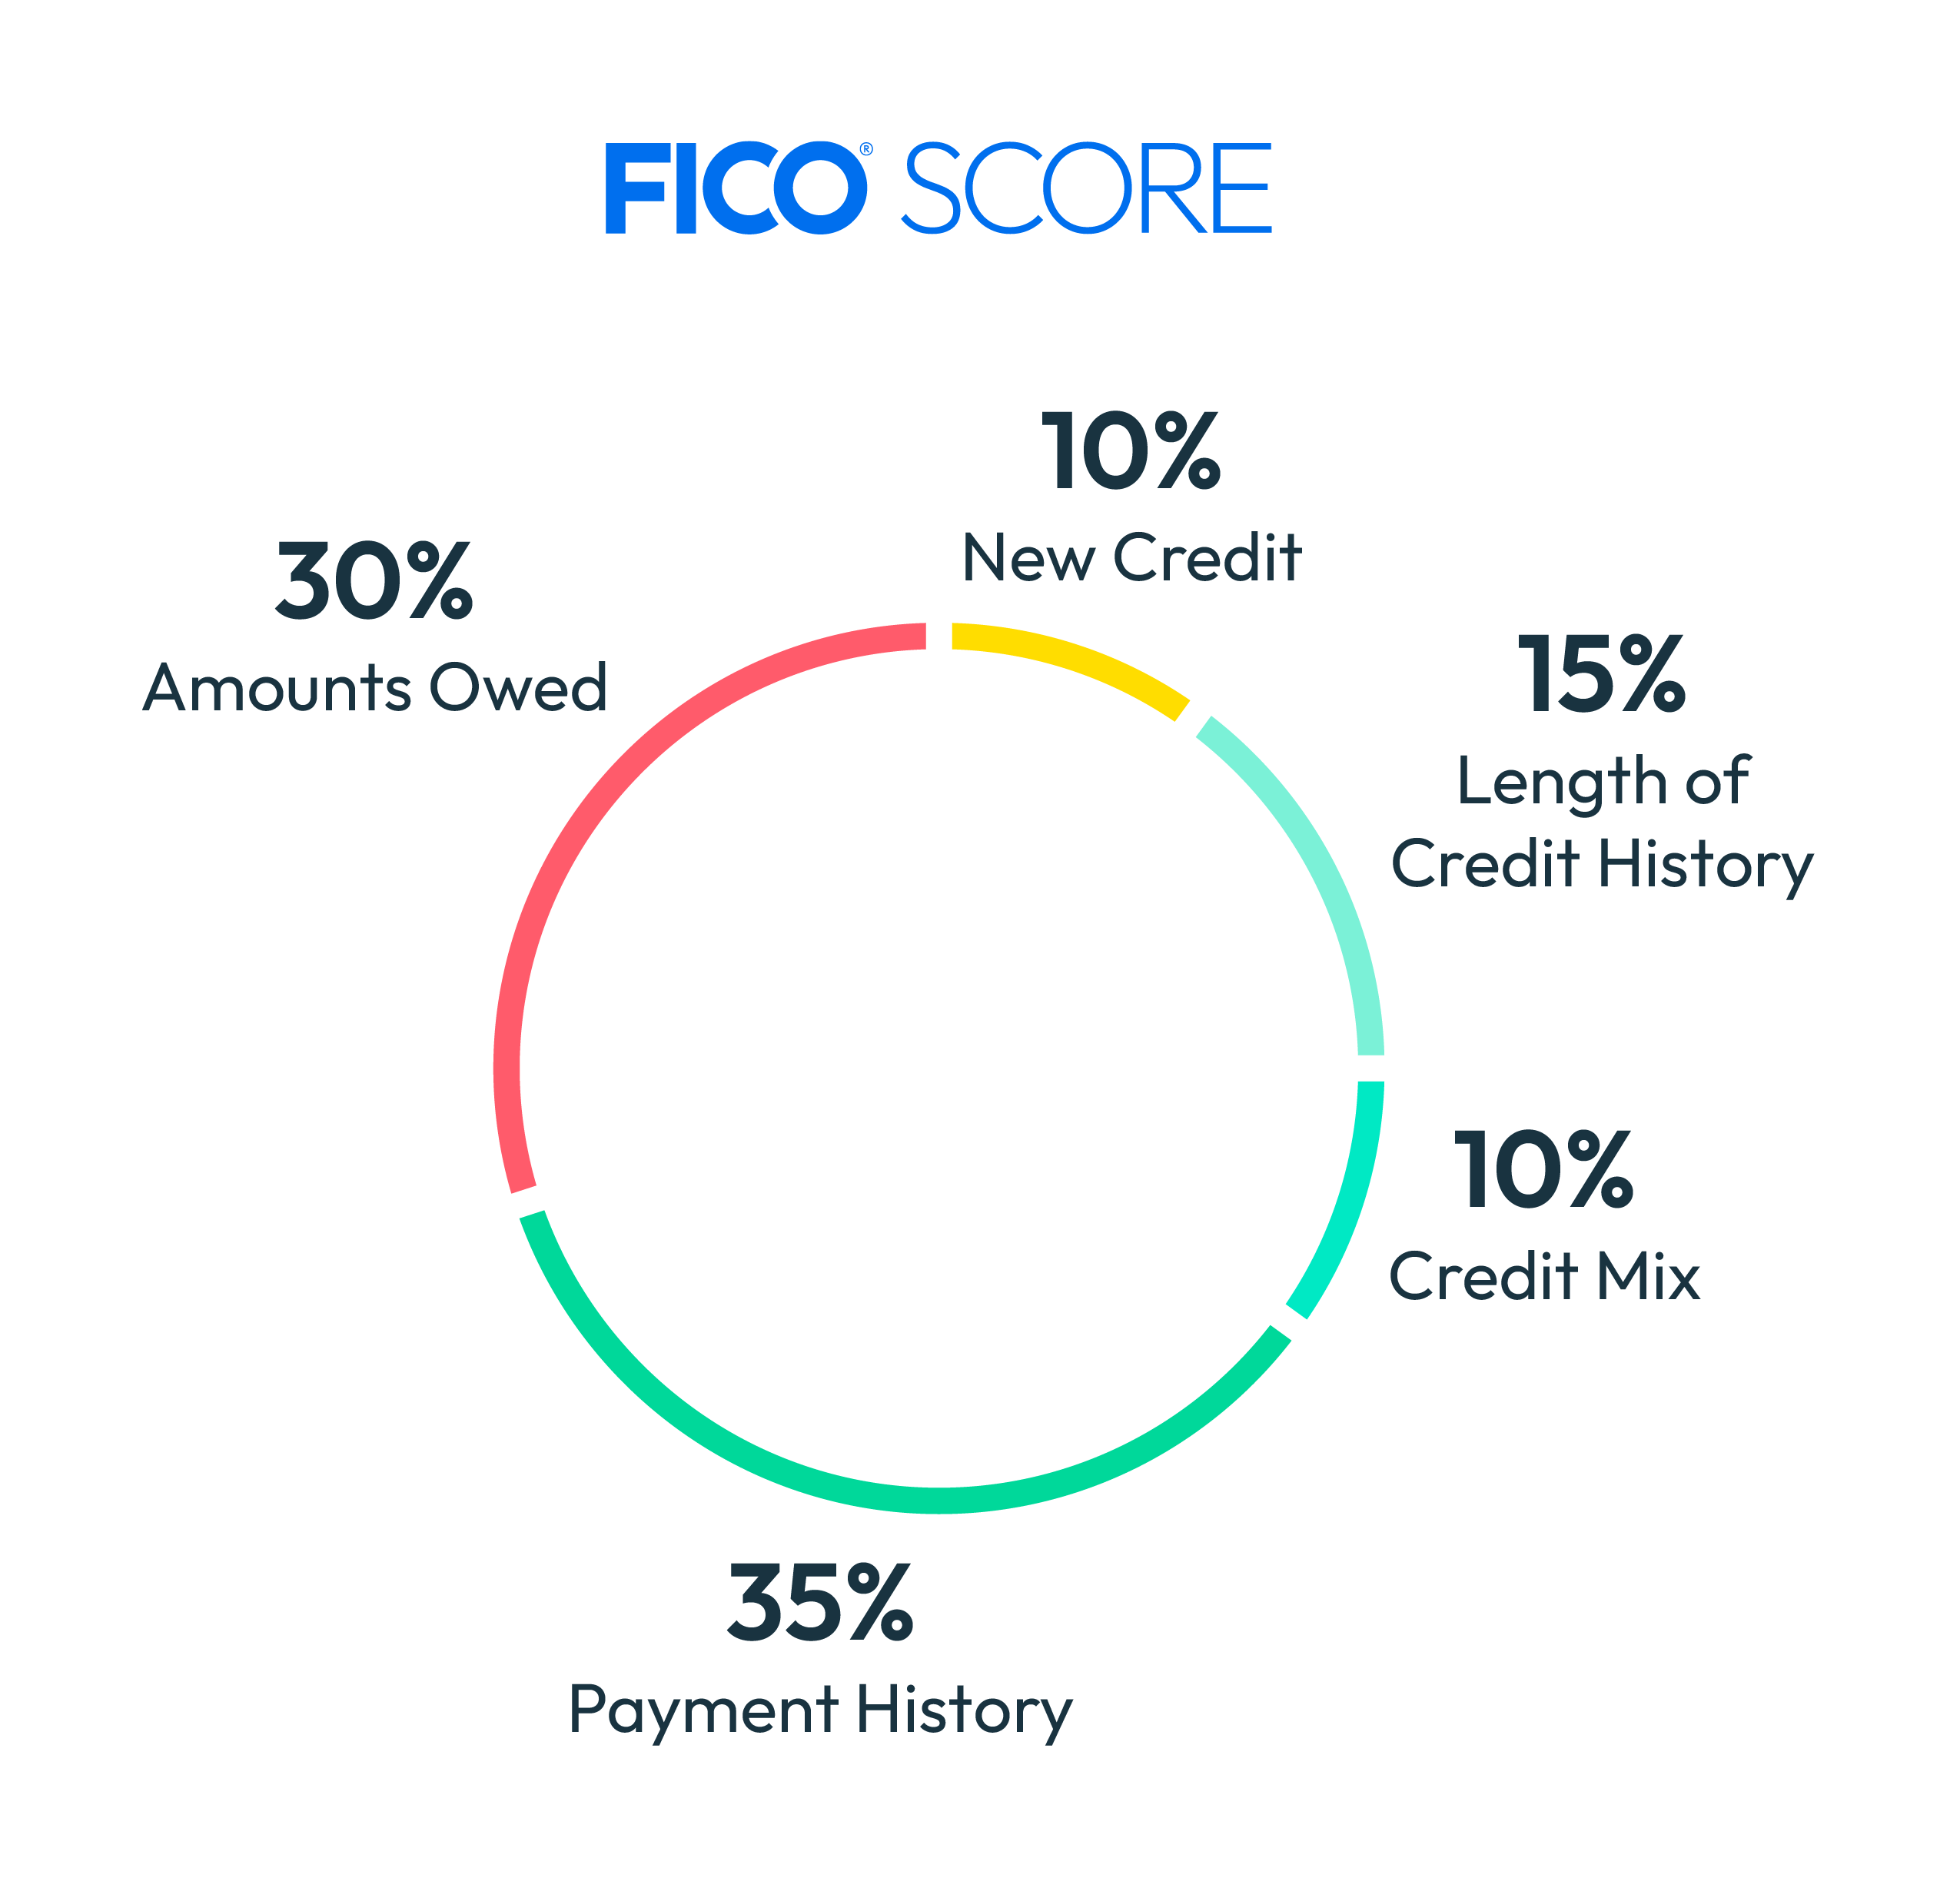

In [10]:
Image("score-graphic.png",width = 500, height = 500)

FICO score = 300 - 850 \
https://www.experian.com/blogs/ask-experian/infographic-what-are-the-different-scoring-ranges/
- Poor credit: 300 to 579 
- Fair credit: 580 to 669 
- Good credit: 670 to 739
- Very good credit: 740 to 799
- Exceptional credit: 800 to 850


~ Formula

$SCORE = 300 + 550 * ( 0.35 * PH + 0.30 * AO + 0.1 * NC + 0.15 * LCH + 0.1 * CM )$

Payment History ( 30 dienas bus šī dataset max limits )
- Viss, kas ir 0 un mazāks = 1
- 0 - 30 = 1 - (Kavetas dienas / 30)
- Viss, kas ir kavēts over 30 dienas ir 0

KOLONNA: Delay_from_due_date

Amounts owed
- Credit_Utilization_ratio ( Manos sintētiskajos datos ir tik no 25 - 45, tehniski jau var pārrēķināt no jauna bet parejas kolonnas ir tik pat sintētiski dīvainas ( Outstanding debt / Credit limit x 100 ) 
  - < 10 ir izcili = 1
  - < 30 ir labi 0.7
  - < 40 ir švaki 0.25
  - Lielaks par 40 = slitki 0
    
KOLONNA: Credit_Utilization_ratio
    
New Credit
- Jo mazāk kartes/ konti/ aizdevumi/ pieprasījumi jo labāk
https://www.myfico.com/credit-education/credit-scores/new-credit

Jauna kolonna "New_credit" = Num_Bank_Accounts + Num_Credit_Card + Num_of_Loan + Num_Credit_Inquiries

Credit Mix
- Ja good = 1
- Ja standard = 0.5
- Ja bad = 0
- 
KOLONNA: Credit_Mix

Length of Credit history
- Viss >= 20 == 1
- < 20 = gadi / 20

KOLONNA: Credit_History_Age

In [11]:
def phv(x, max_d = 30):
    if x <= 0:
        return 1.0
    if x >= max_d:
        return 0.0
    return 1 - (x / max_d)

def aov(x):
    if x <= 10:
        return 1.0
    if (x > 10) and (x < 30):
        return 0.7
    if (x >= 30 ) and ( x < 40):
        return 0.25
    return 0.0

def cmv(x):
    if x == "Good":
        return 1.0
    if x == "Standard":
        return 0.5
    return 0.0

def lchv(x, max_y = 20):
    return min(1.0, x / 20)


In [12]:
df["New_Credit_Sum"] = df["Num_Bank_Accounts"] + df["Num_Credit_Card"] + df["Num_of_Loan"] + df["Num_Credit_Inquiries"]

In [13]:
df["New_Credit_Sum"].describe()

count      29344.0
mean     23.060762
std      21.583141
min            2.0
25%           16.0
50%           21.0
75%           30.0
max         1113.5
Name: New_Credit_Sum, dtype: Float64

In [14]:
def ncv(x, max_c = 20):
    if x >= max_c:
        return 0.0
    return 1 - (x / max_c)

In [15]:
df["Payment_History_Value"] = df["Delay_from_due_date"].apply(phv)
df["Amount_Owed_Value"] = df["Credit_Utilization_Ratio"].apply(aov)
df["Credit_Mix_Value"] = df["Credit_Mix"].apply(cmv)
df["Credit_History_Value"] = df["Credit_History_Age"].apply(lchv)
df["New_Credit_Value"] = df["New_Credit_Sum"].apply(ncv)

In [16]:
df[["Payment_History_Value","Amount_Owed_Value","Credit_Mix_Value","Credit_History_Value","New_Credit_Value" ]].describe().T

,count,mean,std,min,25%,50%,75%,max
Payment_History_Value,29344.0,0.384265,0.316238,0.0,0.033333,0.366667,0.666667,1.0
Amount_Owed_Value,29344.0,0.403088,0.233585,0.0,0.250000,0.250000,0.700000,0.7
Credit_Mix_Value,29344.0,0.506748,0.366883,0.0,0.000000,0.500000,1.000000,1.0
Credit_History_Value,29344.0,0.771488,0.268767,0.0,0.550000,0.900000,1.000000,1.0
New_Credit_Value,29344.0,0.119596,0.172304,0.0,0.000000,0.000000,0.200000,0.9


In [17]:
df["Credit_Score"] = 300 + 550 * ( 
    0.35 * df["Payment_History_Value"] + 
    0.30 * df["Amount_Owed_Value"] + 
    0.1 * df["New_Credit_Value"] + 
    0.15 * df["Credit_History_Value"] + 
    0.1 * df["Credit_Mix_Value"] 
)

In [18]:
# df.to_csv("Aprekini.csv")

In [19]:
df["Credit_Score"].describe()

count    29344.000000
mean       538.577088
std        101.198360
min        304.125000
25%        459.500000
50%        538.333333
75%        616.250000
max        786.750000
Name: Credit_Score, dtype: float64

In [20]:
# conn = sqlite.connect("./SQLite/Creditscore.sqlite")

In [21]:
# df.to_sql("./SQLite/Creditscore.sqlite", con=conn)

In [22]:
# df.to_csv("./PBI/CreditScore.csv")

In [23]:
# df.to_csv("iztiritsBACKUP.csv")

### Predictive modeļi 
#### Risk Underwriting / Fraud Prevention /Customer Acquisition

https://www.youtube.com/watch?v=7eh4d6sabA0 - Machine Learning <br>
https://www.youtube.com/watch?v=pWOoYpJsaDc - Credit scoring models <br>
https://www.youtube.com/watch?v=TyvYZ26alZs - XGBoost / Gradient Boosted Trees <br>
https://kth.diva-portal.org/smash/get/diva2:1811727/FULLTEXT01.pdf - Degree Project in Mathematical Statistics / A Gradient Boosting Tree Approach
for Behavioural Credit Scoring

#### Risk Underwriting

In [24]:
df.dtypes

ID                                  object
Customer_ID                         object
Month                               object
Name                                object
Age                                  Int64
SSN                                 object
Occupation                          object
Annual_Income                      float64
Monthly_Inhand_Salary              float64
Num_Bank_Accounts                    int64
Num_Credit_Card                      int64
Interest_Rate                        int64
Num_of_Loan                          Int64
Type_of_Loan                        object
Delay_from_due_date                  int64
Num_of_Delayed_Payment             float64
Changed_Credit_Limit               float64
Num_Credit_Inquiries               float64
Credit_Mix                          object
Outstanding_Debt                   float64
Credit_Utilization_Ratio           float64
Credit_History_Age                   Int64
Payment_of_Min_Amount               object
Total_EMI_p

In [25]:
df_skait = df.select_dtypes(include=['int64', 'float64', 'Int64'])

In [26]:
df_skait.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,29344.0,33.527672,10.727371,14.0,25.0,33.0,42.0,56.0
Annual_Income,29344.0,47289.701259,36850.918211,7005.93,18465.2875,34975.015,66482.74,179987.28
Monthly_Inhand_Salary,29344.0,3911.94558,3047.61589,303.645417,1546.693542,2905.14,5482.111066,15204.63333
Num_Bank_Accounts,29344.0,5.510087,2.583368,0.0,4.0,6.0,8.0,11.0
Num_Credit_Card,29344.0,5.639858,3.341424,0.0,4.0,5.0,7.0,230.0
Interest_Rate,29344.0,15.828653,61.981718,1.0,8.0,14.0,21.0,5261.0
Num_of_Loan,29344.0,3.877999,2.221237,0.0,2.0,4.0,5.0,9.0
Delay_from_due_date,29344.0,21.849237,15.192817,-5.0,10.0,19.0,29.0,67.0
Num_of_Delayed_Payment,29344.0,14.502658,29.360016,-2.5,9.0,14.0,18.5,1786.0
Changed_Credit_Limit,29344.0,10.676519,6.611919,0.06,5.7575,9.54,15.25,34.21


In [27]:
df_skait.info()

<class 'pandas.core.frame.DataFrame'>
Index: 29344 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Age                       29344 non-null  Int64  
 1   Annual_Income             29344 non-null  float64
 2   Monthly_Inhand_Salary     29344 non-null  float64
 3   Num_Bank_Accounts         29344 non-null  int64  
 4   Num_Credit_Card           29344 non-null  int64  
 5   Interest_Rate             29344 non-null  int64  
 6   Num_of_Loan               29344 non-null  Int64  
 7   Delay_from_due_date       29344 non-null  int64  
 8   Num_of_Delayed_Payment    29344 non-null  float64
 9   Changed_Credit_Limit      29344 non-null  float64
 10  Num_Credit_Inquiries      29344 non-null  float64
 11  Outstanding_Debt          29344 non-null  float64
 12  Credit_Utilization_Ratio  29344 non-null  float64
 13  Credit_History_Age        29344 non-null  Int64  
 14  Total_EMI_p

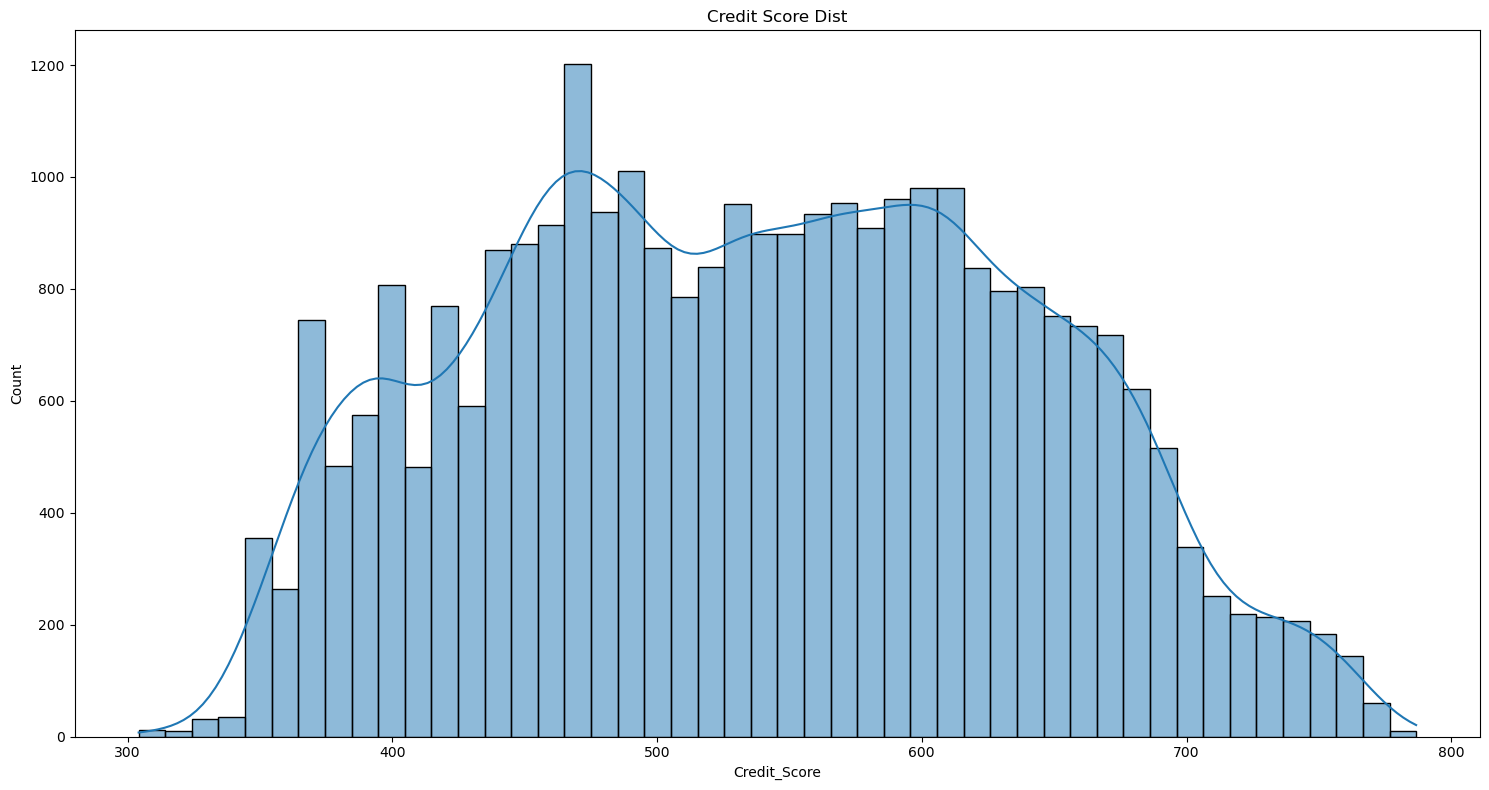

In [28]:
plt.figure(figsize = (15,8))

sns.histplot(df_skait["Credit_Score"], kde = True)
plt.title("Credit Score Dist")

plt.tight_layout()
plt.show()

In [29]:
df_skait["Credit_Score"].mean()

np.float64(538.5770884451109)

In [30]:
df_skait["Credit_Score"].median()

538.3333333333333

In [31]:
df_skait["Credit_Score"].mode()

0    394.875
Name: Credit_Score, dtype: float64

<Axes: >

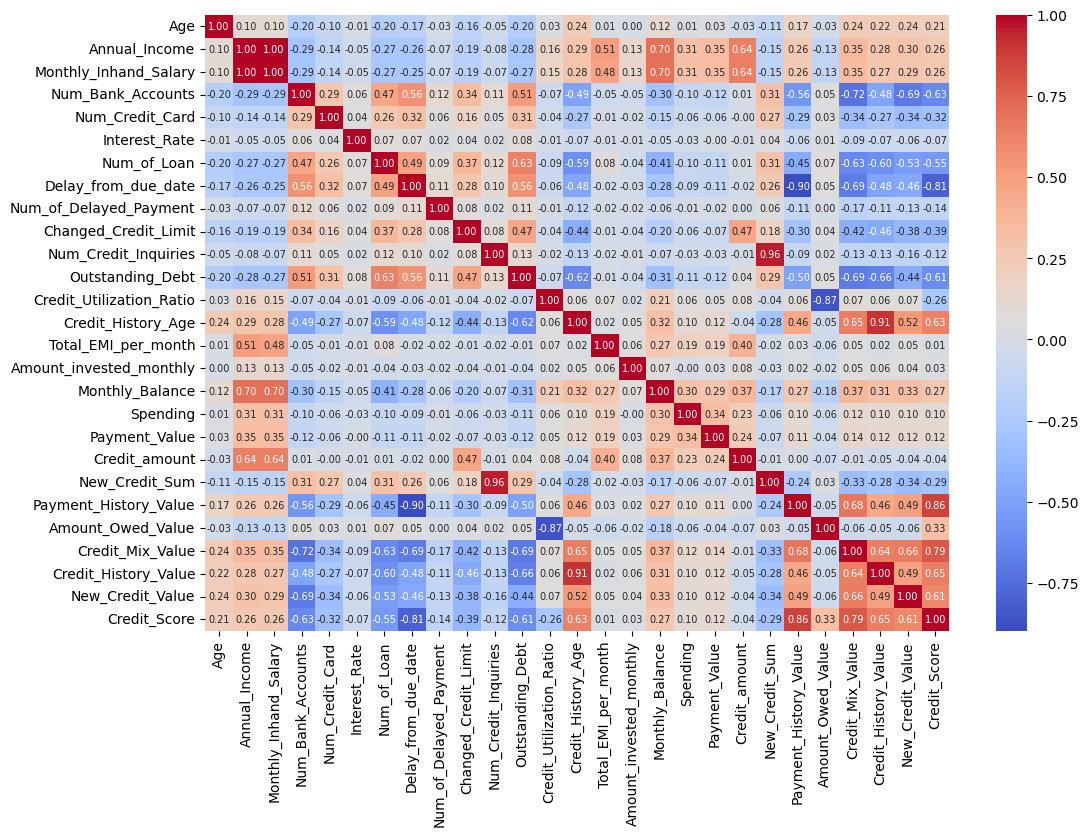

In [32]:
plt.figure(figsize=(12,8))
sns.heatmap(df_skait.corr(),annot=True, annot_kws = {"size" : 7},fmt = ".2f", cmap='coolwarm')

Text(0.5, 1.0, 'Scatter - DebtOutstanding')

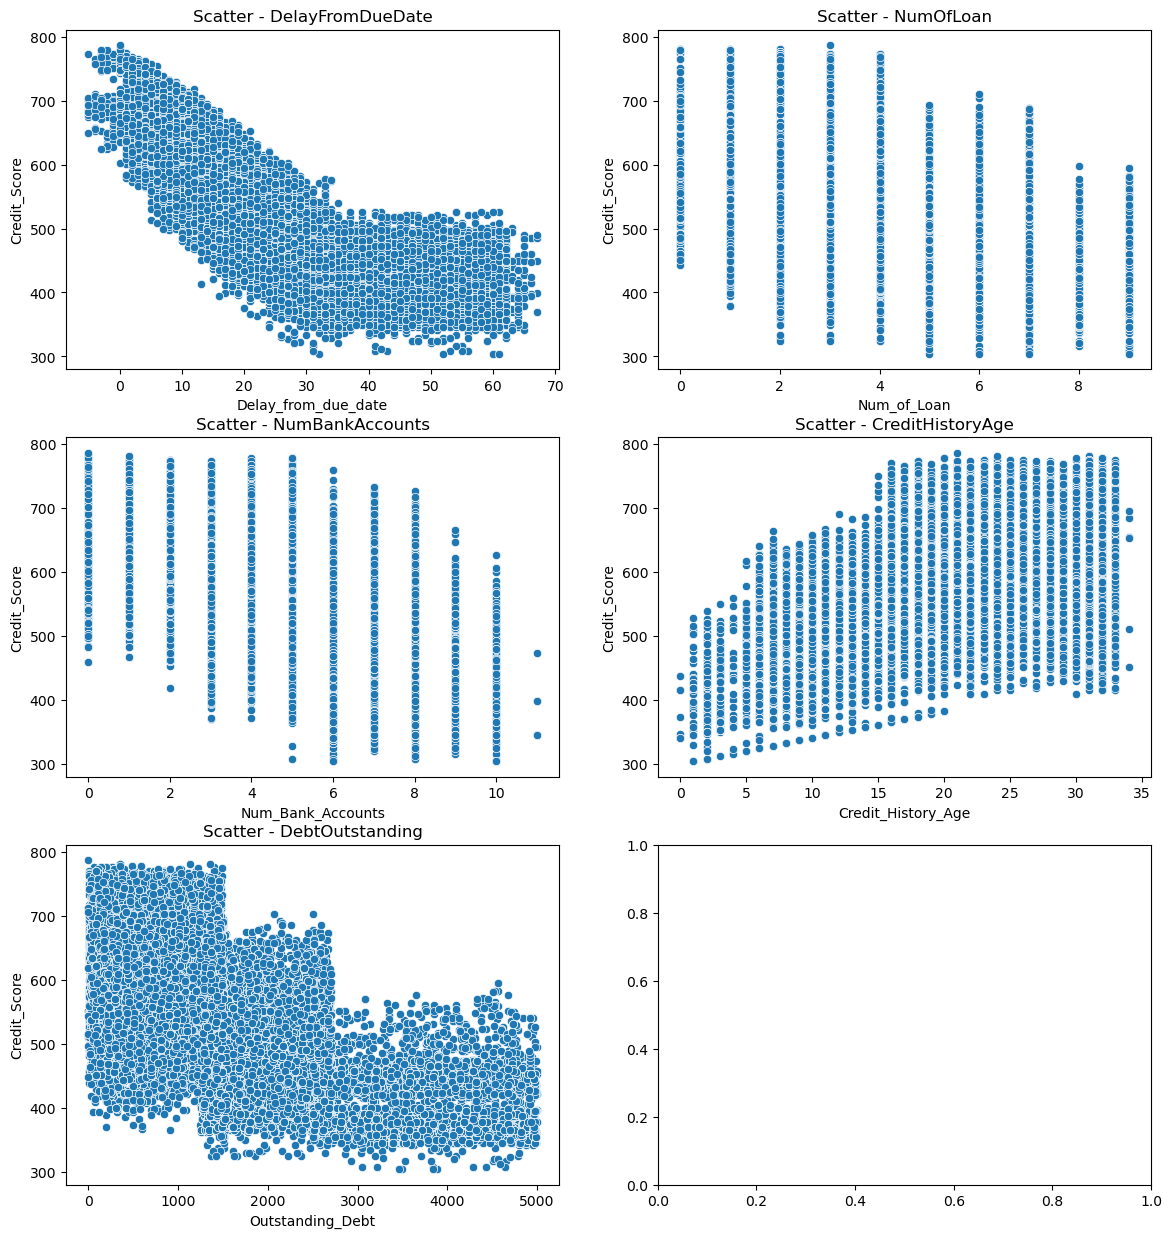

In [33]:
fig, axes = plt.subplots(3,2,figsize = (14,15))

sns.scatterplot(x="Delay_from_due_date", y="Credit_Score", data=df, ax = axes[0,0])
axes[0,0].set_title("Scatter - DelayFromDueDate")

sns.scatterplot(x="Num_of_Loan", y="Credit_Score", data=df, ax = axes[0,1])
axes[0,1].set_title("Scatter - NumOfLoan")

sns.scatterplot(x="Num_Bank_Accounts", y="Credit_Score", data=df, ax = axes[1,0])
axes[1,0].set_title("Scatter - NumBankAccounts")

sns.scatterplot(x="Credit_History_Age", y="Credit_Score", data=df, ax = axes[1,1])
axes[1,1].set_title("Scatter - CreditHistoryAge")

sns.scatterplot(x="Outstanding_Debt", y="Credit_Score", data=df, ax = axes[2,0])
axes[2,0].set_title("Scatter - DebtOutstanding")


In [34]:
df_skait.columns

Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly',
       'Monthly_Balance', 'Spending', 'Payment_Value', 'Credit_amount',
       'New_Credit_Sum', 'Payment_History_Value', 'Amount_Owed_Value',
       'Credit_Mix_Value', 'Credit_History_Value', 'New_Credit_Value',
       'Credit_Score'],
      dtype='object')

In [35]:
X = df_skait.drop(columns = [
    "Credit_Score",
    "New_Credit_Value",
    "Credit_History_Value",
    "Credit_Mix_Value",
    "Amount_Owed_Value",
    "Payment_History_Value",
    "New_Credit_Sum",
    "Credit_amount"])

In [36]:
X.columns

Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly',
       'Monthly_Balance', 'Spending', 'Payment_Value'],
      dtype='object')

In [37]:
Y = df_skait["Credit_Score"]

In [38]:
x_train, x_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)

In [39]:
x_test.shape

(5869, 19)

In [40]:
x_train.shape

(23475, 19)

##### Choosing the number of estimators
https://towardsdatascience.com/how-to-choose-the-number-of-estimators-for-gradient-boosting-8d06920ab891/ <br>
https://github.com/gurezende/Studying/blob/master/Python/sklearn/GradientBoosting.ipynb

In [41]:
steps = [
    ('scale', StandardScaler()),
    ('GBR', GradientBoostingRegressor(n_estimators=500, learning_rate=0.05))
]

# Instance Pipeline and fit
pipe = Pipeline(steps).fit(x_train, y_train)
# Predict
preds = pipe.predict(x_test)
# RMSE of the predictions
print(f'RMSE: { round(np.sqrt(mean_squared_error(y_test, preds)),1 )}')
# Data Y mean
print(f'Data y mean: {round( Y.mean(),1 )}')

RMSE: 7.1
Data y mean: 538.6


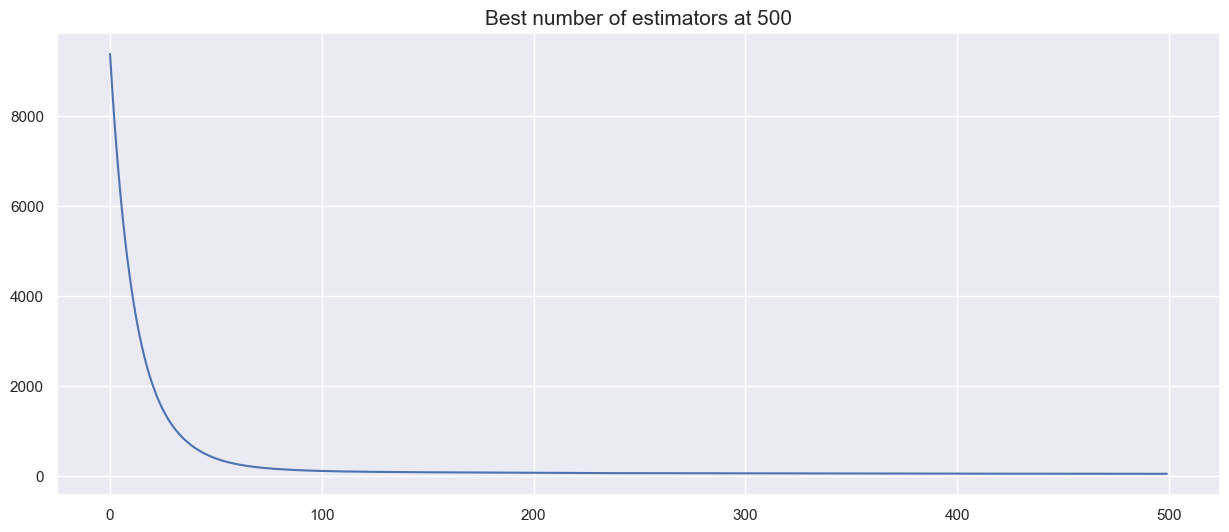

In [42]:
#Model
gbr = GradientBoostingRegressor(n_estimators=500, learning_rate=0.05).fit(x_train, y_train)

# Loop for the best number
errors = [ mean_squared_error(y_test, preds)
for preds in gbr.staged_predict(x_test)]
best_n_estimators = np.argmin(errors) + 1

#Plot
sns.set(rc={'figure.figsize':(15,6)})
g=sns.lineplot(x=range(500), y=errors)
g.set_title(f'Best number of estimators at {best_n_estimators}', size=15);

<div class = "alert alert-block alert-info">
    Tehniski var mierīgi ņemt 200 estimatorus, aptuvenā kļūda nav baigi atšķirīgā starp 200 un 500.
    </div>

##### Modelis

In [43]:
model = GradientBoostingRegressor(
    random_state = 42,
    n_estimators=500,
    learning_rate = 0.05,
    max_depth = 3
)

model.fit(x_train, y_train)

,loss,'squared_error'
,learning_rate,0.05
,n_estimators,500
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [44]:
cs_pred_train = model.predict(x_train)
cs_pred_test = model.predict(x_test)

In [45]:
# https://media.datacamp.com/legacy/image/upload/v1676302389/Marketing/Blog/Scikit-Learn_Cheat_Sheet.pdf

In [46]:
r2_train = r2_score(y_train, cs_pred_train)
r2_test = r2_score(y_test, cs_pred_test)

mae_cs = mean_absolute_error(y_test, cs_pred_test)
mse_cs = mean_squared_error(y_test, cs_pred_test)
rmse_cs = root_mean_squared_error(y_test, cs_pred_test)

print(f"R^2 train: {r2_train}\nR^2 test: {r2_test}\nMAE: {mae_cs}\nMSE: {mse_cs}\nRMSE: {rmse_cs}")

R^2 train: 0.9954190949425669
R^2 test: 0.9950440209479405
MAE: 5.197170992046078
MSE: 50.60390881632079
RMSE: 7.113642443665607


<div class = "alert alert-block alert-success">
    R sq vērtības norāda, ka modelis izskaidro 99.5% no visām Kredītreitinga vērtībām, kas ir... pārāk labi, visticamāk dēļ tā, ka tie nav reāli, bet sintētiski dati, kā arī es ļoti daudz laika pavadīju uz viņu tīrīšanu. Bet modelis viennozīmīgi saskata likumsakarības datos.<br><br>
    Modelis vidēji kļūdās par 5.2 punktiem <br><br>
    Nav īsti nepieciešamība vērtēt modeli ar MSE, kļūdas tiek liktas kvadrātā, līdz ar to tiek ļoti sodītas "lielas kļūdas", bet šinī gadījumā ir viena konkrēta anomālija, kur prognozētais kredītreitings atšķiras par ~ 55 punktiem no īstā. <br><br>
    RMSE, kas ir sakne no MSE, norāda uz 7 punktu kļūdu, kas uz lielās bildes, ir ļoti labi.
    </div>

In [47]:
# https://www.datacamp.com/tutorial/visualize-machine-learning-models

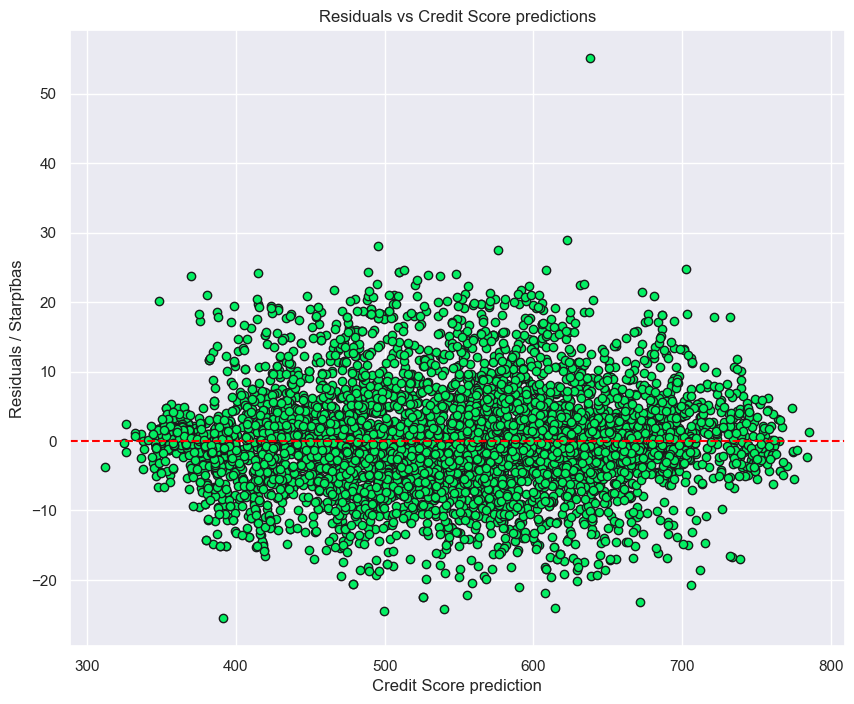

In [48]:
residuals = y_test - cs_pred_test
plt.figure(figsize = (10,8))
plt.scatter(cs_pred_test, residuals, color = "#03EF62", edgecolors = "k")
plt.axhline(0, color = "red", linestyle = "dashed")
plt.xlabel("Credit Score prediction")
plt.ylabel("Residuals / Starpības")
plt.title("Residuals vs Credit Score predictions")
plt.grid(True)
plt.show()

<div class = "alert alert-block alert-success">
    Atlikumi ir izkaisīti ap nulli. Respektīvi modelis prognozē kredītreitingu stabili, nedodot izteikti pārāk augstu vai zemu reitingu. ( neskaitot to vienu brīnumu ar 55 punktu kļūdu ).
    </div>

In [49]:
df["Model_CS1"] = model.predict(X)

In [50]:
df["Model_CS_Error1"] = df["Credit_Score"] - df["Model_CS1"]

In [51]:
# joblib.dump(model, "creditscore_ml_predict_GBR.joblib")

##### Modelis 2

In [52]:
df_skait.columns

Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly',
       'Monthly_Balance', 'Spending', 'Payment_Value', 'Credit_amount',
       'New_Credit_Sum', 'Payment_History_Value', 'Amount_Owed_Value',
       'Credit_Mix_Value', 'Credit_History_Value', 'New_Credit_Value',
       'Credit_Score'],
      dtype='object')

In [53]:
X2 = df[["Num_Bank_Accounts",
    "Num_Credit_Card",
    "Num_of_Loan",
    "Num_Credit_Inquiries",
    "Delay_from_due_date",
    "Credit_Utilization_Ratio",
    "Credit_Mix_Value",
    "Credit_History_Age"]]

In [54]:
X2.head()

,Num_Bank_Accounts,Num_Credit_Card,Num_of_Loan,Num_Credit_Inquiries,Delay_from_due_date,Credit_Utilization_Ratio,Credit_Mix_Value,Credit_History_Age
0,3,4,4,4.0,3,35.030402,1.0,22
1,3,4,4,4.0,3,33.053114,1.0,22
2,3,4,4,4.0,-1,33.811894,1.0,22
3,3,4,4,4.0,4,32.430559,1.0,23
4,2,4,1,5.0,3,25.926822,1.0,27


In [55]:
Y2 = df["Credit_Score"]

In [56]:
x2_train, x2_test, y2_train, y2_test = train_test_split(X2,Y2, test_size = 0.2, random_state = 42)

In [57]:
model2 = GradientBoostingRegressor(
    random_state = 42,
    n_estimators=500,
    learning_rate = 0.05,
    max_depth = 3
)

model2.fit(x2_train, y2_train)

,loss,'squared_error'
,learning_rate,0.05
,n_estimators,500
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [58]:
cs2_pred_train = model2.predict(x2_train)
cs2_pred_test = model2.predict(x2_test)

In [59]:
r2_train2 = r2_score(y2_train, cs2_pred_train)
r2_test2 = r2_score(y2_test, cs2_pred_test)

mae_cs2 = mean_absolute_error(y2_test, cs2_pred_test)
mse_cs2 = mean_squared_error(y2_test, cs2_pred_test)
rmse_cs2 = root_mean_squared_error(y2_test, cs2_pred_test)

print(f"R^2 train: {r2_train2}\nR^2 test: {r2_test2}\nMAE: {mae_cs2}\nMSE: {mse_cs2}\nRMSE: {rmse_cs2}")

R^2 train: 0.9994917111450787
R^2 test: 0.9993972160272181
MAE: 1.7138185072231178
MSE: 6.154833358691938
RMSE: 2.4808936613027046


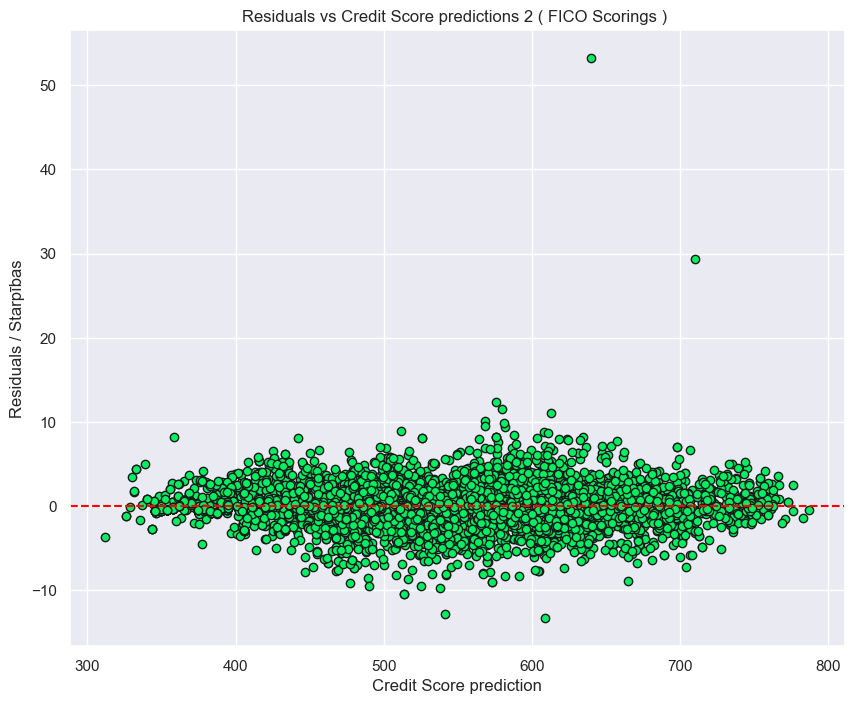

In [60]:
residuals2 = y2_test - cs2_pred_test
plt.figure(figsize = (10,8))
plt.scatter(cs2_pred_test, residuals2, color = "#03EF62", edgecolors = "k")
plt.axhline(0, color = "red", linestyle = "dashed")
plt.xlabel("Credit Score prediction")
plt.ylabel("Residuals / Starpības")
plt.title("Residuals vs Credit Score predictions 2 ( FICO Scorings ) ")
plt.grid(True)
plt.show()

<div class = "alert alert-block alert-success">
    R sq vērtības norāda, ka modelis izskaidro 99.9% no visām Kredītreitinga vērtībām, kas ir... pārāk labi, visticamāk dēļ tā, ka tie nav reāli, bet sintētiski dati, kā arī es ļoti daudz laika pavadīju uz viņu tīrīšanu. Bet modelis viennozīmīgi saskata likumsakarības datos.<br><br>
    Modelis vidēji kļūdās par 1.7 punktiem <br><br>
    Vērtējot modeli ar MSE, kļūda ir stipri mazāka salīdzinot ar iepriekšējo modeli.
    </div>

In [61]:
df["Model_CS2"] = model2.predict(X2)

In [62]:
df["Model_CS_Error2"] = df["Credit_Score"] - df["Model_CS2"]

In [109]:
df.loc[df["Model_CS_Error2"] > 25,:]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Score,Model_CS1,Model_CS_Error1,Model_CS2,Model_CS_Error2,Fraud_Anomaly_Score,Fraud_Flag,Fraud_Status,NC_Fraud_Anomaly_Score,NC_Fraud_Flag
3854,0x4330,CUS_0xb018,November,Callusn,35,088-10-2997,Teacher,128189.37,10390.447500,2,...,739.083333,721.218830,17.864503,709.693826,29.389507,0.110967,1,Normal,0.120631,1
18071,0xe9c9,CUS_0xdd3,December,Dougz,41,536-31-0878,Accountant,30802.79,2522.149511,5,...,693.250000,638.148047,55.101953,640.022014,53.227986,0.143312,1,Normal,0.183736,1


In [117]:
df.loc[df["Customer_ID"] == "CUS_0xb018",["Credit_Score", "Model_CS2", "Model_CS_Error2", "Customer_ID","Month", "Num_Bank_Accounts",
    "Num_Credit_Card",
    "Num_of_Loan",
    "Num_Credit_Inquiries",
    "Delay_from_due_date",
    "Credit_Utilization_Ratio",
    "Credit_Mix_Value",
    "Credit_History_Age"]].T

,3852,3853,3854,3855
Credit_Score,707.0,639.166667,739.083333,607.083333
Model_CS2,706.96297,638.43074,709.693826,607.293198
Model_CS_Error2,0.03703,0.735927,29.389507,-0.209865
Customer_ID,CUS_0xb018,CUS_0xb018,CUS_0xb018,CUS_0xb018
Month,September,October,November,December
Num_Bank_Accounts,2,2,2,2
Num_Credit_Card,7,7,7,7
Num_of_Loan,2,2,2,2
Num_Credit_Inquiries,2.0,2.0,2.0,2.0
Delay_from_due_date,9,8,4,13


In [118]:
df.loc[df["Customer_ID"] == "CUS_0xdd3",["Credit_Score", "Model_CS2", "Model_CS_Error2", "Customer_ID","Month", "Num_Bank_Accounts",
    "Num_Credit_Card",
    "Num_of_Loan",
    "Num_Credit_Inquiries",
    "Delay_from_due_date",
    "Credit_Utilization_Ratio",
    "Credit_Mix_Value",
    "Credit_History_Age"]].T

,18068,18069,18070,18071
Credit_Score,627.25,674.0,586.916667,693.25
Model_CS2,626.881752,675.36127,587.820299,640.022014
Model_CS_Error2,0.368248,-1.36127,-0.903632,53.227986
Customer_ID,CUS_0xdd3,CUS_0xdd3,CUS_0xdd3,CUS_0xdd3
Month,September,October,November,December
Num_Bank_Accounts,5,5,5,5
Num_Credit_Card,5,5,5,5
Num_of_Loan,3,3,3,3
Num_Credit_Inquiries,2.0,5.0,5.0,5.0
Delay_from_due_date,9,12,14,9


#### Fraud prevention

https://www.youtube.com/watch?v=Y1x51i1936M - Isolation Forests: Identify Outliers in Data / Teorija <br>
https://www.youtube.com/watch?v=R_4bFnNHqNY - Using Isolation Forest for Outlier Detection <br>
https://www.youtube.com/watch?v=O9VvmWj-JAk - Using Isolation Forest for Outlier Detection

In [66]:
df.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Spending', 'Payment_Value', 'Credit_amount', 'New_Credit_Sum',
       'Payment_History_Value', 'Amount_Owed_Value', 'Credit_Mix_Value',
       'Credit_History_Value', 'New_Credit_Value', 'Credit_Score', 'Model_CS1',
       'Model_CS_Error1', 'Model_CS2', 'Model_CS_Error2'],
      dtype='object')

In [67]:
df_skait.columns

Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly',
       'Monthly_Balance', 'Spending', 'Payment_Value', 'Credit_amount',
       'New_Credit_Sum', 'Payment_History_Value', 'Amount_Owed_Value',
       'Credit_Mix_Value', 'Credit_History_Value', 'New_Credit_Value',
       'Credit_Score'],
      dtype='object')

In [68]:
df_anomaly_fraud = df_skait[["Num_of_Loan","Delay_from_due_date","Outstanding_Debt","New_Credit_Sum","Credit_History_Age","Credit_Utilization_Ratio"]]

In [69]:
X_fraud = df_anomaly_fraud

In [70]:
iso = IsolationForest(contamination=0.03, n_estimators=300, random_state = 42)
iso.fit(X_fraud)

df["Fraud_Anomaly_Score"] = iso.decision_function(X_fraud)
df["Fraud_Flag"] = iso.predict(X_fraud)

In [71]:
df["Fraud_Flag"].value_counts(normalize = True)

Fraud_Flag
 1    0.969977
-1    0.030023
Name: proportion, dtype: float64

In [72]:
df["Fraud_Flag"].value_counts()

Fraud_Flag
 1    28463
-1      881
Name: count, dtype: int64

In [73]:
df["Fraud_Status"] = df["Fraud_Flag"].apply(lambda x: "Fraud" if x == -1 else "Normal")

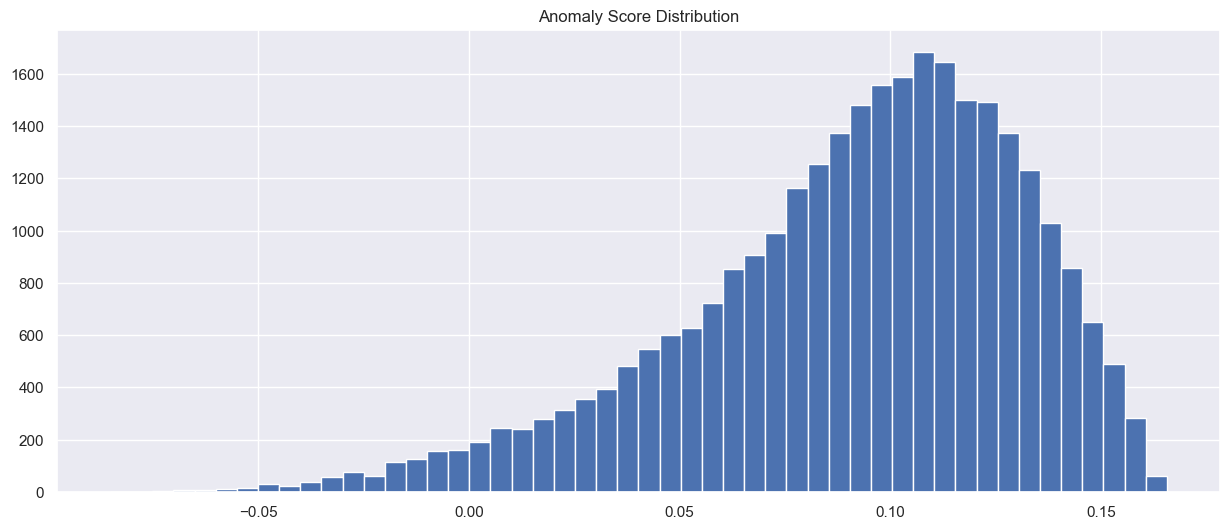

In [74]:
plt.hist(df["Fraud_Anomaly_Score"], bins=50)
plt.title("Anomaly Score Distribution")
plt.show()

<div class = "alert alert-block alert-info">
    Sadalījums anomālijām ir adekvāts, lielākā daļa klientu atrodas pozitīvajā zonā ( > 0.00 ) un nav apzīmēti kā "Fraudulent" ( < 0.00 ) <br>
    Es pieļāvu, ka aptuveni 3% no datiem varētu būt anomālijas, krāpnieciskas tendences ( pie modeļa iekļaujot contamination = 0.03 ), tādu rezultātu arī modelis atgriež.
    </div>

In [75]:
df_skait.columns

Index(['Age', 'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Outstanding_Debt', 'Credit_Utilization_Ratio',
       'Credit_History_Age', 'Total_EMI_per_month', 'Amount_invested_monthly',
       'Monthly_Balance', 'Spending', 'Payment_Value', 'Credit_amount',
       'New_Credit_Sum', 'Payment_History_Value', 'Amount_Owed_Value',
       'Credit_Mix_Value', 'Credit_History_Value', 'New_Credit_Value',
       'Credit_Score'],
      dtype='object')

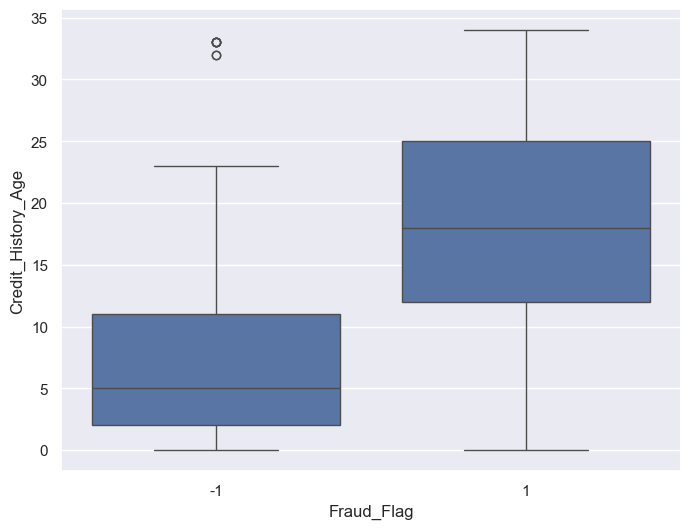

In [76]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="Fraud_Flag", y="Credit_History_Age")
plt.show()

<div class = "alert alert-block alert-success">
    Anomālijās, pārsvarā atzīmēti klienti, ar īsāku kredītvēsturi. 1. Kvartile ir no 0 - 2 gadiem, 2. Kvartile ir no 2 - 5 gadiem, 3. Kvartile ir no mediānas (5 gadiem) līdz 11. gadiem. Respektīvi aptuveni 75% no klientiem, kas ir apzīmēti kā anomālijas kredītvēsture ir līdz 10 gadiem.
    </div>

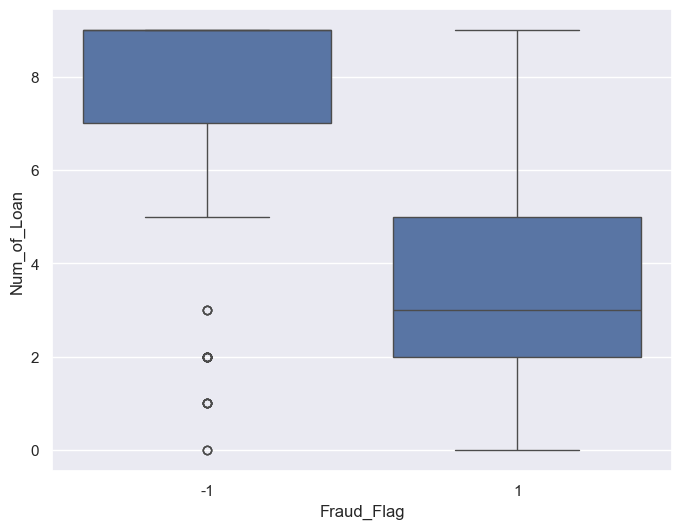

In [77]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="Fraud_Flag", y="Num_of_Loan")
plt.show()

<div class = "alert alert-block alert-success">
    Galvenokārt kā anomālijas ir noteikti klienti, kam ir 7 - 9 aizdevumi, šis strādātu vairāk kā riska signāls, ka klients ir iespējams pārāk daudz aizņēmies. Pārējiem klientiem, sadalījums ir aptuveni starp 2 - 5 aizdevumiem.
    </div>

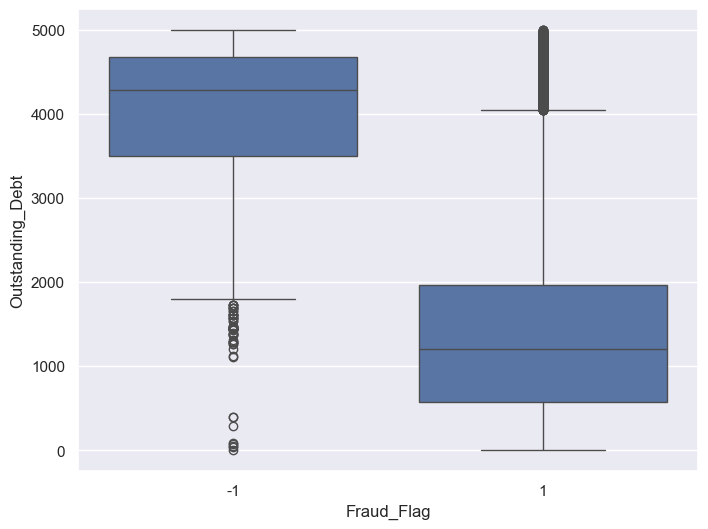

In [78]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="Fraud_Flag", y="Outstanding_Debt")
plt.show()

<div class = "alert alert-block alert-warning">
    Līdzīgi, kā pārējos gadījumos, visi klienti ar aizdomīgi lielu parādu ir atzīmēti kā anomālijas.
    </div>

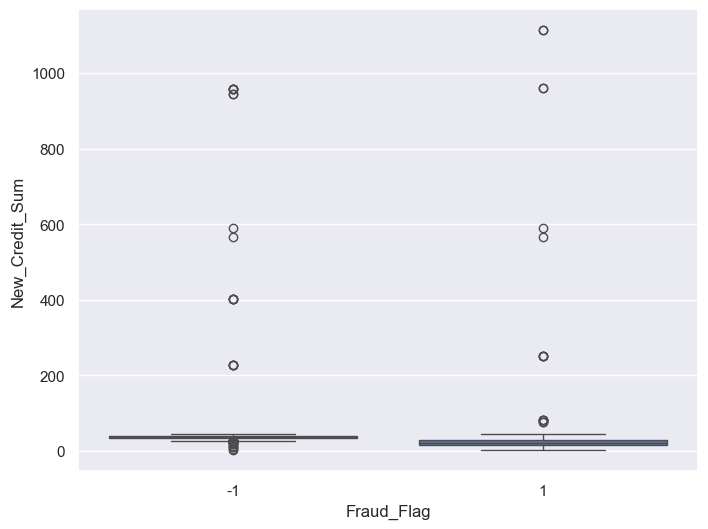

In [79]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="Fraud_Flag", y="New_Credit_Sum")
plt.show()

<div class = "alert alert-block alert-danger">
    Šī ir modeļa neizdevusies daļa, mana vēlme bija, ka visi klienti, kas būs interesējušies par kredītiem ekstremāli daudz reizes, tiks norādīti kā "Fraud". Nevarētu būt tālāk no patiesības. Protams spēlē arī tas, ka es modelim devu vairākus faktorus, kā rezultātā skatoties uz lielo bildi nolēma neflaggot kā "Fraud". Šo var salabot, izveidojot vēlvienu modeli, kas atzīmē "Fraud", balstoties tikai uz interesējošo kredītu skaitu.
    </div>

In [80]:
df_CreditSum = df_skait[["Num_Credit_Inquiries"]]
X_NewCreditFraud = df_CreditSum
iso_nc = IsolationForest(contamination=0.03, n_estimators=300, random_state = 42)
iso_nc.fit(X_NewCreditFraud)

df["NC_Fraud_Anomaly_Score"] = iso_nc.decision_function(X_NewCreditFraud)
df["NC_Fraud_Flag"] = iso_nc.predict(X_NewCreditFraud)

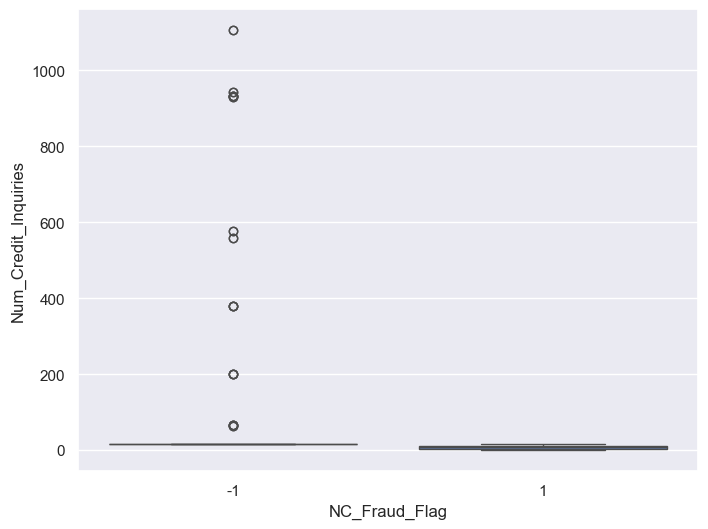

In [81]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="NC_Fraud_Flag", y="Num_Credit_Inquiries")
plt.show()

<div class = "alert alert-block alert-success">
    Tagad ir papildus Fraud vērtība, kas nav tas ideālākais variants, bet tas, ko mēs varam novērot ir, ka izteikti ir atzīmēti klienti, kas ir interesējušies par absurdu lielu kredītu skaitu. PROTAMS, šie dati visticamāk ir, kas tāds, ko pie tīrīšanas vajadzētu sakopt, bet es vēlējos redzēt, kā modelis strādās ar šo, kā rezultātā ekstremālās vērtības atstāju. <br> Skaidrs ir arī tas, ka, manā gadījumā, IsolationForest strādā labāk ar vienu konkrētu faktoru.
            </div>

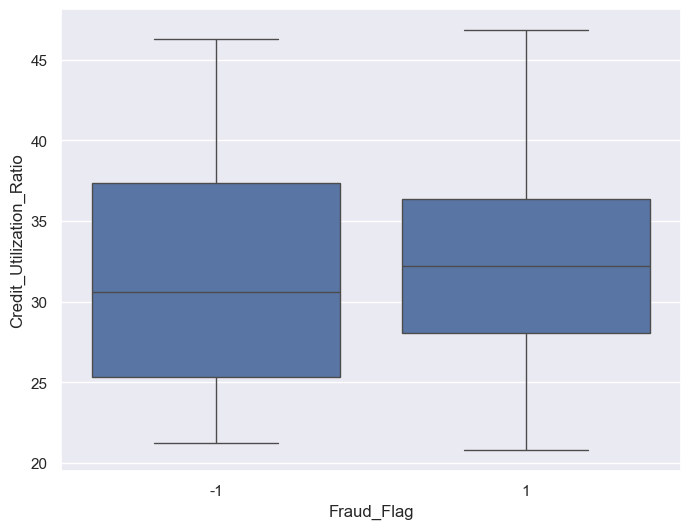

In [82]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="Fraud_Flag", y="Credit_Utilization_Ratio")
plt.show()

<div class = "alert alert-block alert-warning">
    CUR ir galīgi garām, datos nav tik ekstremālas vērtības, sadalījums ir līdzīgs.<br>
    Šis "dataset" nav tas labākais piemērs priekš "Fraud Detection". Pašlaik vienīgā vērtība, kas signalizētu krāpniecību, ir interese par simtiem kredītu. Pārējās apkopotās vērtības, vairāk vai mazāk signalizē par riska grupām un kategorijām.
    </div>

#### Customer acquisition

<div class = "alert alert-block alert-info">
    Šī sadaļa ir nepilnīga, jo man trūka jautājumi uz kuriem meklēt atbildes. Bija neizpratne par nepieciešamo mērķi un rezultātu. Vai ir nepieciešams izveidot modeli, kas prognozē mārketinga kampaņu izmaksas ? ( Visticamāk vajadzētu papildus target vērtības un kampaņas uz kurām trenēt modeli. ) Vai ir nepieciešams identificēt klientu grupas, piemēram, zema riska klientus ? Opcijas ir daudz un dažādas, līdz ar ko, es beigās nolēmu vienkārši plotot klientu informāciju, lai iepazītu viņus tuvāk.
    </div>

In [83]:
df.columns

Index(['ID', 'Customer_ID', 'Month', 'Name', 'Age', 'SSN', 'Occupation',
       'Annual_Income', 'Monthly_Inhand_Salary', 'Num_Bank_Accounts',
       'Num_Credit_Card', 'Interest_Rate', 'Num_of_Loan', 'Type_of_Loan',
       'Delay_from_due_date', 'Num_of_Delayed_Payment', 'Changed_Credit_Limit',
       'Num_Credit_Inquiries', 'Credit_Mix', 'Outstanding_Debt',
       'Credit_Utilization_Ratio', 'Credit_History_Age',
       'Payment_of_Min_Amount', 'Total_EMI_per_month',
       'Amount_invested_monthly', 'Payment_Behaviour', 'Monthly_Balance',
       'Spending', 'Payment_Value', 'Credit_amount', 'New_Credit_Sum',
       'Payment_History_Value', 'Amount_Owed_Value', 'Credit_Mix_Value',
       'Credit_History_Value', 'New_Credit_Value', 'Credit_Score', 'Model_CS1',
       'Model_CS_Error1', 'Model_CS2', 'Model_CS_Error2',
       'Fraud_Anomaly_Score', 'Fraud_Flag', 'Fraud_Status',
       'NC_Fraud_Anomaly_Score', 'NC_Fraud_Flag'],
      dtype='object')

In [84]:
df["Type_of_Loan"].head(10)

0                              Not Specified
1                              Not Specified
2                              Not Specified
3                              Not Specified
4                        Credit-Builder Loan
5                        Credit-Builder Loan
6                        Credit-Builder Loan
7                        Credit-Builder Loan
8    Auto Loan, Auto Loan, and Not Specified
9    Auto Loan, Auto Loan, and Not Specified
Name: Type_of_Loan, dtype: object

In [85]:
LoanTypes = df["Type_of_Loan"]

In [86]:
LoanTypes = LoanTypes.str.replace("and","")
# LoanTypes

In [87]:
LoanTypes = LoanTypes.str.split(",")
# LoanTypes

In [88]:
LoanTypes_exploded = LoanTypes.explode().str.strip()

In [89]:
LoanTypes_exploded.value_counts()

Type_of_Loan
Not Specified              18784
Payday Loan                 8452
Credit-Builder Loan         8268
Debt Consolidation Loan     7920
Home Equity Loan            7888
Student Loan                7880
Mortgage Loan               7740
Auto Loan                   7672
Name: count, dtype: int64

In [90]:
LoanTypes_exploded = LoanTypes_exploded[LoanTypes_exploded != "Not Specified"]

In [91]:
ValueCountsLoans = LoanTypes_exploded.value_counts()

In [92]:
ValueCountsLoans = ValueCountsLoans / 4

In [93]:
ValueCountsLoans

Type_of_Loan
Payday Loan                2113.0
Credit-Builder Loan        2067.0
Debt Consolidation Loan    1980.0
Home Equity Loan           1972.0
Student Loan               1970.0
Mortgage Loan              1935.0
Auto Loan                  1918.0
Name: count, dtype: float64

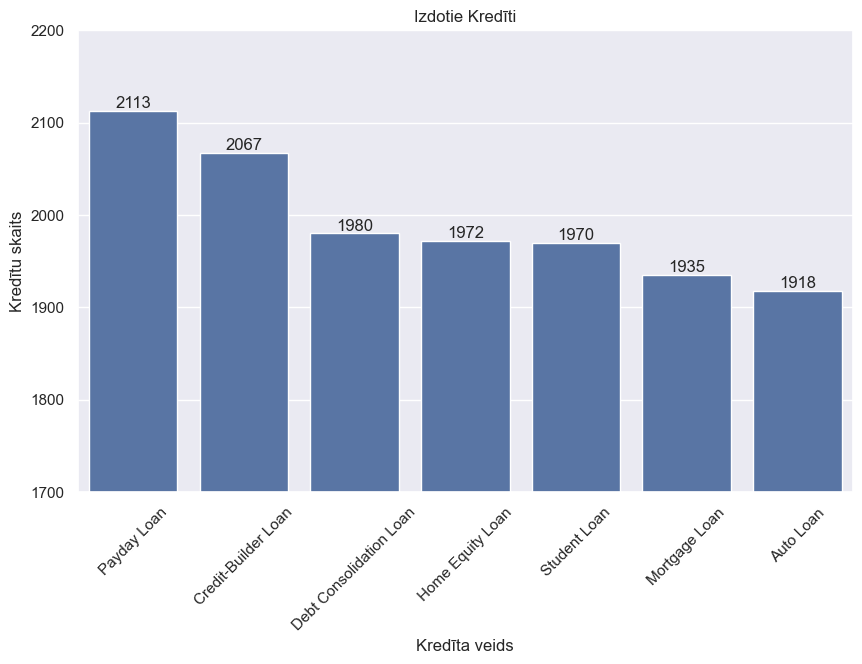

In [94]:
plt.figure(figsize=(10,6))
LoanCount = sns.barplot(ValueCountsLoans)
for container in LoanCount.containers:
    LoanCount.bar_label(container)
plt.title("Izdotie Kredīti")
plt.ylim((1700,2200))
plt.xlabel("Kredīta veids")
plt.ylabel("Kredītu skaits")
plt.xticks(rotation=45)
plt.show()

<div class = "alert alert-block alert-info">
    Populārākie aizdevumi šobrīd ir "Ātrie kredīti" un kredīti, kas paredzēti kredītvēstures veidošanai/uzlabošanai.
    </div>

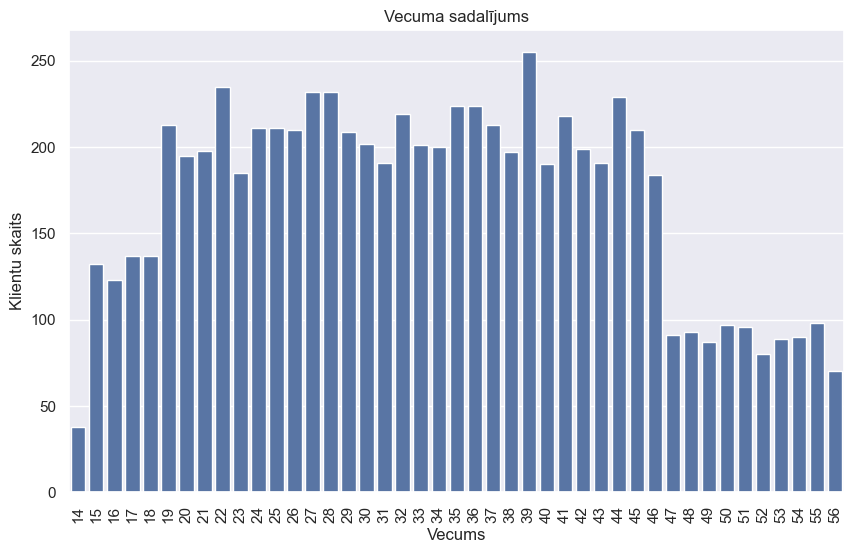

In [95]:
Vecumuskaits = df["Age"].value_counts()
Vecumuskaits = Vecumuskaits / 4

plt.figure(figsize=(10,6))
Age = sns.barplot(Vecumuskaits)
# for container in Age.containers:
    # Age.bar_label(container, padding=10)
plt.title("Vecuma sadalījums")
plt.xlabel("Vecums")
plt.ylabel("Klientu skaits")
plt.xticks(rotation=90)
plt.show()

<div class = "alert alert-block alert-warning">
    Klientu bāzi pārsvarā dominē personas 20 - 45 gadu vecumā, tie ir ekonomiski visaktīvākie iedzīvotaji. <br>
    Acīmredzot arī nepilngadīgas personas apkalpojam.
    </div>

<div class = "alert alert-block alert-danger">
    Šos klientus vajadzētu izvērtēt Complience dept., mums kā klients ir 16 gadīgs mehāniķis, 17 gadīgi grāmatveži utt.
    </div>

In [96]:
df.loc[df["Age"] < 18,:]

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Score,Model_CS1,Model_CS_Error1,Model_CS2,Model_CS_Error2,Fraud_Anomaly_Score,Fraud_Flag,Fraud_Status,NC_Fraud_Anomaly_Score,NC_Fraud_Flag
144,0x17ba,CUS_0x4080,September,ra Alperx,16,995-37-8920,Mechanic,29469.98,2227.831667,7,...,469.125000,467.255703,1.869297,469.741766,-0.616766,0.069877,1,Normal,0.172733,1
145,0x17bb,CUS_0x4080,October,ra Alperx,16,995-37-8920,Mechanic,29469.98,2227.831667,7,...,394.875000,393.305128,1.569872,395.042806,-0.167806,0.087271,1,Normal,0.172733,1
146,0x17bc,CUS_0x4080,November,ra Alperx,16,995-37-8920,Mechanic,29469.98,2227.831667,7,...,399.000000,398.134998,0.865002,398.374587,0.625413,0.075311,1,Normal,0.172733,1
147,0x17bd,CUS_0x4080,December,ra Alperx,16,995-37-8920,Mechanic,29469.98,2227.831667,7,...,399.000000,398.134998,0.865002,398.374587,0.625413,0.075665,1,Normal,0.172733,1
180,0x1826,CUS_0x8e9b,September,Rachelle Younglaic,16,925-51-5335,Entrepreneur,55829.79,4369.482500,10,...,386.625000,388.626516,-2.001516,387.383658,-0.758658,0.039437,1,Normal,0.185048,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49755,0x25d15,CUS_0x504e,December,Emilyf,17,569-84-9250,Accountant,72572.46,6233.705000,4,...,457.666667,462.583517,-4.916851,459.654273,-1.987606,0.124205,1,Normal,0.194981,1
49900,0x25ece,CUS_0x1232,September,Lawderr,17,441-26-1297,Developer,14937.49,1142.790833,8,...,469.125000,474.872972,-5.747972,469.741766,-0.616766,0.083175,1,Normal,0.198012,1
49901,0x25ecf,CUS_0x1232,October,Lawderr,17,441-26-1297,Developer,14937.49,1142.790833,8,...,469.125000,474.886240,-5.761240,469.741766,-0.616766,0.076765,1,Normal,0.198012,1
49902,0x25ed0,CUS_0x1232,November,Lawderr,17,441-26-1297,Developer,14937.49,1142.790833,8,...,473.250000,479.688467,-6.438467,473.093789,0.156211,0.071839,1,Normal,0.198012,1


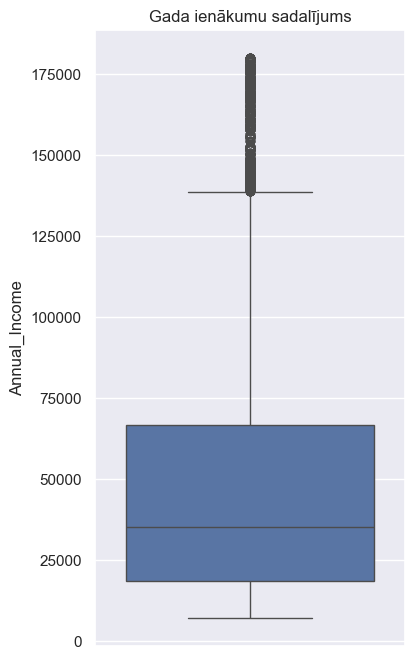

In [97]:
plt.figure(figsize=(4,8))
sns.boxplot(df["Annual_Income"])
plt.title("Gada ienākumu sadalījums")
plt.show()


<Axes: xlabel='Annual_Income', ylabel='Count'>

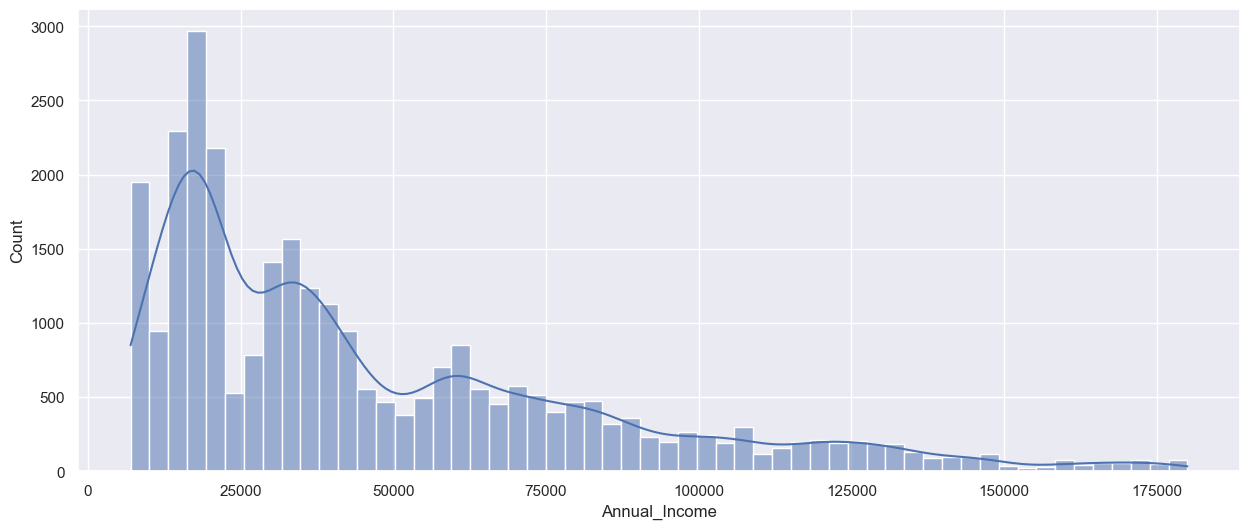

In [98]:
sns.histplot(df["Annual_Income"], kde = True)

<div class = "alert alert-block alert-info">
    Lielākā daļa mūsu klientu, gadā pelna sākot no 20 - 40 tūkstošiem.
    </div>

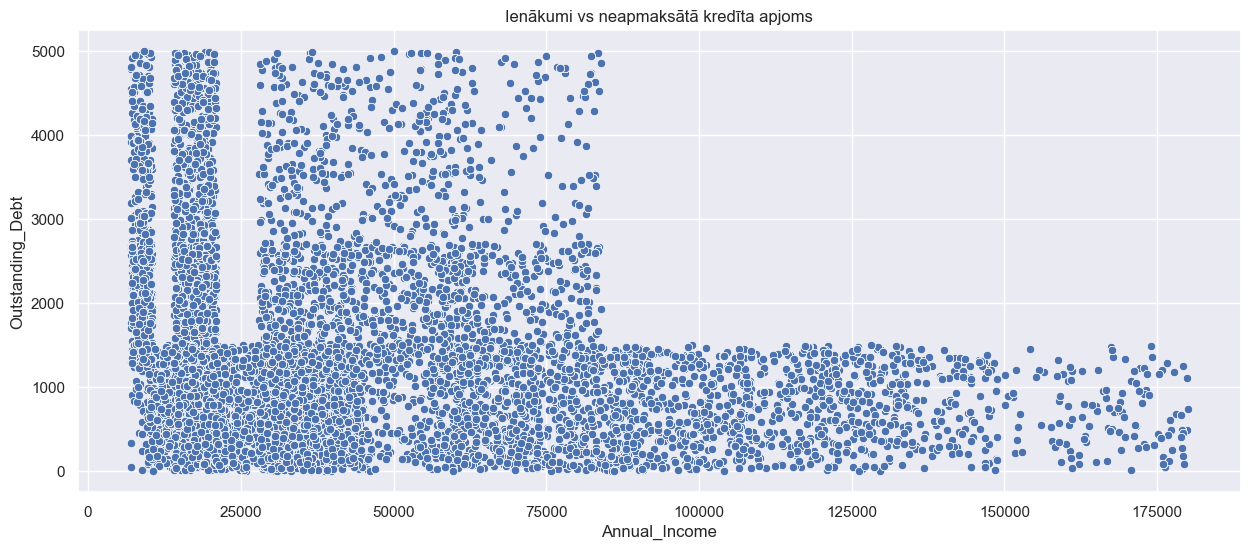

In [99]:
sns.scatterplot(data=df, x="Annual_Income", y="Outstanding_Debt")
plt.title("Ienākumi vs neapmaksātā kredīta apjoms")
plt.show()

<div class = "alert alert-block alert-warning">
    Klienti ar viszemāko ienākumu līmeni uzņemas vislielākās parādsaistības.
    </div>

In [100]:
# df.to_excel("Final.xlsx")